# Section 5. Evaluation - Figures

## Load results of experiments

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import os
import json
import yaml
import pandas as pd
from pathlib import Path
from typing import Dict, Any


def flatten_dict(d: Dict[str, Any], parent_key='', sep='.') -> Dict[str, Any]:
    """Flatten nested dictionaries."""
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


def compute_specificity(y_true, y_pred):
    """Compute specificity: TN / (TN + FP)"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0


def extract_metrics(eval_data: list, threshold: float = 0.5) -> Dict[str, float]:
    """
    Compute precision, recall, specificity, and F1 score from raw predictions.
    Each dictionary maps hashes to [true_class, predicted_probability].
    """
    metrics = {}
    partitions = ['Negative', 'Positive', '25 manipulated features', '50 manipulated features', '100 manipulated features']
    
    for idx, partition in zip(range(1, 6), partitions):
        entry = eval_data[idx]
        y_true = [0 for v in entry.values()] if partition == 'Negative' else [1 for v in entry.values()]
        y_scores = [v[1] for v in entry.values()]
        y_pred = [1 if s >= threshold else 0 for s in y_scores]

        #precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0) if partition != 'Negative' else None
        #f1 = f1_score(y_true, y_pred, zero_division=0)
        specificity = compute_specificity(y_true, y_pred) if partition == 'Negative' else None

        #metrics[f"{partition}_precision"] = precision
        metrics[f"{partition}_recall"] = recall
        metrics[f"{partition}_specificity"] = specificity
        #metrics[f"{partition}_f1"] = f1

    return metrics


def build_dataframe_from_dirs(root_dir: str) -> pd.DataFrame:
    rows = []

    for folder in Path(root_dir).iterdir():
        if not folder.is_dir():
            continue

        try:
            # Load config
            with open(folder / "config.yaml") as f:
                config = yaml.safe_load(f)
            flat_config = flatten_dict(config)

            # Load evaluation
            with open(folder / "evaluation.json") as f:
                eval_data = json.load(f)
            model_name = eval_data[0].get("name", folder.name)
            metrics = extract_metrics(eval_data)

            # Combine
            row = {"model_name": model_name, **flat_config, **metrics}
            rows.append(row)
        except Exception as e:
            print(f"Failed to process {folder}: {e}")

    return pd.DataFrame(rows)


In [10]:
df = build_dataframe_from_dirs("../experiments/out")
# Replace in col titles manipulated features by -FSA
df = df.rename(columns={col: col.replace(' manipulated features', '-FSA') for col in df.columns})

## Adversarial Training (Figure 3)

### Code

In [18]:
def plot_adversarial_recalls(df: pd.DataFrame):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.colors as mcolors
    import pandas as pd
    import numpy as np

    def adjust_color_lightness(color, amount=0.5):
        try:
            c = mcolors.cnames[color]
        except:
            c = color
        c = mcolors.to_rgb(c)
        c = [min(1, max(0, x * amount)) for x in c]
        return c

    sns.set_theme(context="paper", style="whitegrid", font_scale=1.2)

    df = df[df["model_name"].str.startswith(("tab-adv-train", "natural-train"), na=False)].copy()
    df["adversarial_trainer.m"] = pd.to_numeric(df["adversarial_trainer.m"], errors="coerce")

    # Adversarial models
    adv_df = df[df["model_name"].str.startswith("tab-adv-train", na=False)].copy()
    if "adversarial_trainer.delta_bound" in adv_df.columns:
        adv_df["adversarial_trainer.delta_bound"] = adv_df["adversarial_trainer.delta_bound"].astype(int)
    if "adversarial_trainer.feat_selection" in adv_df.columns:
        adv_df["adversarial_trainer.feat_selection"] = adv_df["adversarial_trainer.feat_selection"].astype(str)

    # Natural model
    natural_df = df[df["model_name"].str.startswith("natural-train", na=False)].copy()

    # --- Define Plotting Palettes and Markers ---
    marker_map = { 25: 'o', 50: '^', 75: 's', 100: 'D' }
    base_colors = { "topk": "#008080", "random": "#d35400" }
    lightness = { 25: 1.6, 50: 1.3, 75: 1.0, 100: 0.7 }

    # --- Extend the list of plots to include 'Negative' for specificity ---
    plot_scenarios = ['Positive', '25-FSA', '50-FSA', '100-FSA', 'Negative']

    for scenario in plot_scenarios:
        # --- NEW: Conditional logic for the fifth plot ---
        if scenario == 'Negative':
            y_col = 'Negative_specificity'
            y_label = 'TNR'
            plot_title = 'Negative Detection Rate'
        else:
            y_col = f"{scenario}_recall"
            y_label = 'TPR'
            if scenario == "Positive":
                plot_title = "Positive Detection Rate (clean)"
            else:
                plot_title = f"Positive Detection Rate ({scenario.split(' ')[0]} manipulated features)"
        # --- End of new logic ---


        # Ensure the column exists and is numeric
        if y_col not in adv_df.columns or y_col not in natural_df.columns:
            print(f"Skipping plot for '{scenario}': Column '{y_col}' not found.")
            continue

        adv_df[y_col] = pd.to_numeric(adv_df[y_col], errors="coerce")
        natural_df[y_col] = pd.to_numeric(natural_df[y_col], errors="coerce")

        plt.figure(figsize=(5, 4))

        plot_max_info = {"value": -1.0, "coords": None}
        plot_min_info = {"value": 2.0, "coords": None}

        # --- Plot Adversarial Models ---
        for (feat, delta), group in adv_df.groupby(["adversarial_trainer.feat_selection", "adversarial_trainer.delta_bound"]):
            group = group.sort_values("adversarial_trainer.m").dropna(subset=[y_col])
            if group.empty:
                continue

            base_color = base_colors.get(feat, "gray")
            amount = lightness.get(delta, 1.0)
            color = adjust_color_lightness(base_color, amount=amount)

            xs, ys = group["adversarial_trainer.m"], group[y_col]

            plt.plot(xs, ys, label=f"{feat} / {delta}", marker=marker_map.get(delta, 'x'),
                     color=color, linewidth=1.5, linestyle='-', markersize=8, alpha=0.9)

            # Check for new plot max/min
            local_max_idx, local_min_idx = ys.idxmax(), ys.idxmin()
            if ys[local_max_idx] > plot_max_info["value"]:
                plot_max_info = {"value": ys[local_max_idx], "coords": (xs[local_max_idx], ys[local_max_idx])}
            if ys[local_min_idx] < plot_min_info["value"]:
                plot_min_info = {"value": ys[local_min_idx], "coords": (xs[local_min_idx], ys[local_min_idx])}

        # --- Plot Natural Model ---
        if not natural_df.empty:
            nat_value = natural_df[y_col].dropna().values
            if len(nat_value) > 0:
                y_val = nat_value[0]
                nat_color = "#6a0dad"
                plt.scatter([0], [y_val], color=nat_color, marker='X', s=100, zorder=5, alpha=0.9)
                plt.annotate(f"{y_val:.4f}", (0, y_val), textcoords="offset points", xytext=(0, 8), ha='center', fontsize=10)

                if y_val > plot_max_info["value"]:
                    plot_max_info = {"value": y_val, "coords": (0, y_val)}
                if y_val < plot_min_info["value"]:
                    plot_min_info = {"value": y_val, "coords": (0, y_val)}

        # --- Annotate Best/Worst Points ---
        if plot_max_info["coords"] and plot_max_info["coords"][0] != 0:
            plt.annotate(f"{plot_max_info['value']:.4f}", plot_max_info["coords"], textcoords="offset points", xytext=(0, 8), ha='center', fontsize=10)
        if plot_min_info["coords"] and plot_min_info["coords"][0] != 0 and plot_min_info["coords"] != plot_max_info["coords"]:
            plt.annotate(f"{plot_min_info['value']:.4f}", plot_min_info["coords"], textcoords="offset points", xytext=(0, -16), ha='center', fontsize=10)

        # --- Configure Final Plot Aesthetics ---
        #plt.title(plot_title)
        plt.xlabel("Batch Replay Hyperparameter (m)")
        plt.ylabel(y_label) # Use the dynamic y-axis label

        custom_xticks = [0, 1, 2, 5, 10]
        custom_xtick_labels = ["vanilla", "1", "2", "5", "10"]
        plt.xticks(custom_xticks, custom_xtick_labels)

        max_y = pd.concat([adv_df[y_col], natural_df[y_col]]).max()
        min_y = pd.concat([adv_df[y_col], natural_df[y_col]]).min()
        if pd.notna(max_y):
            #plt.ylim(max(0, min_y - 0.05), min(1, max_y + 0.05))
            plt.ylim(min_y - 0.05,  max_y + 0.05)
            if scenario == 'Negative':
                plt.ylim(min_y - 0.05,  max_y + 0.01)

        # Only show legend on the first plot to avoid redundancy
        if scenario == "Negative":
            #plt.legend(title="Selection / Bound", bbox_to_anchor=(1.05, 1), loc="upper left")
            plt.legend(title="Selection / Bound", loc="best", framealpha=0.5)

        plt.tight_layout()

        # Create figure directory and Save each figure in svg format
        os.makedirs("figures", exist_ok=True)
        plt.savefig(f"figures/adv-train-experiment-{scenario}.pdf")

        plt.show()

### Figure

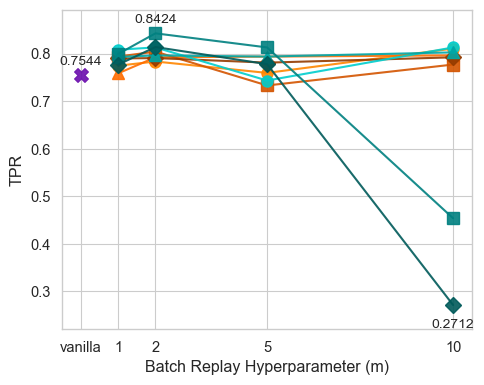

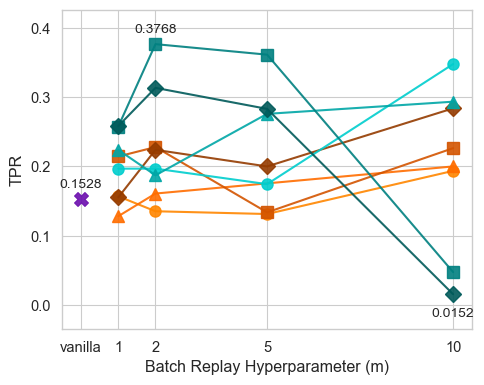

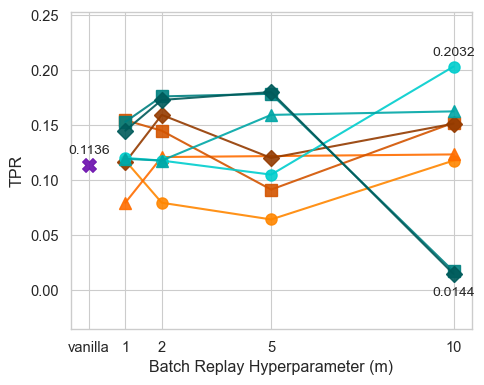

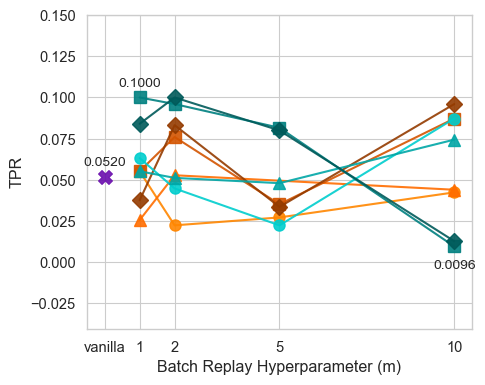

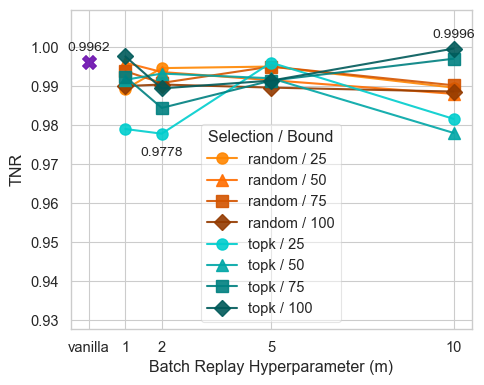

In [19]:
plot_adversarial_recalls(df)

## Label smoothing (Figure 4)

### Code

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_distillation_recalls(df: pd.DataFrame):
    """
    Generates two separate plots for distillation performance:
    1. Positive Detection Rate (Recall) and Negative Detection Rate (Specificity) on Clean Data vs. Label Smoothing.
    2. Positive Detection Rate (Recall) under Evasion Attack vs. Label Smoothing.
    """
    # --- 1. COMMON SETUP FOR ALL PLOTS ---
    sns.set_theme(context="paper", style="whitegrid", font_scale=1.2)

    # Filter the dataframe for relevant models
    df_filtered = df[df["model_name"].str.startswith(("adv-distill", "natural-train"), na=False)].copy()
    df_filtered["distillation.distillation"] = pd.to_numeric(df_filtered["distillation.distillation"], errors="coerce")

    # Separate the data for distilled and natural models
    distill_df = df_filtered[df_filtered["model_name"].str.startswith("adv-distill")].copy()
    natural_df = df_filtered[df_filtered["model_name"].str.startswith("natural-train")].copy()


    # --- 2. GENERATE PLOT 1: PDR (RECALL) AND NDR (SPECIFICITY) ON CLEAN DATA ---
    print("Generating Plot 1: Detection Performance on Clean Data...")
    plt.figure(figsize=(5, 4))

    pdr_recall_col = "Positive_recall"
    ndr_spec_col = "Negative_specificity"
    all_metrics_plot1 = []

    # Plot Positive Detection Rate (Recall)
    if pdr_recall_col in distill_df.columns and pdr_recall_col in natural_df.columns:
        color = "#008080"  # Teal
        marker = 'o'
        distill_df[pdr_recall_col] = pd.to_numeric(distill_df[pdr_recall_col], errors="coerce")
        natural_df[pdr_recall_col] = pd.to_numeric(natural_df[pdr_recall_col], errors="coerce")

        grouped = distill_df.groupby("distillation.distillation")[pdr_recall_col].mean().dropna()
        xs = sorted(grouped.index)
        ys = grouped.loc[xs].values

        if len(xs) > 0:
            plt.plot(xs, ys, label="TPR", color=color, marker=marker, linestyle='-', markersize=8, alpha=0.8, linewidth=1.5)
            all_metrics_plot1.extend(ys)
            if len(ys) > 0:
                max_idx, min_idx = np.argmax(ys), np.argmin(ys)
                plt.annotate(f"{ys[max_idx]:.4f}", (xs[max_idx], ys[max_idx]), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
                if min_idx != max_idx:
                    plt.annotate(f"{ys[min_idx]:.4f}", (xs[min_idx], ys[min_idx]), textcoords="offset points", xytext=(0, -18), ha='center', fontsize=10)

        nat_value = natural_df[pdr_recall_col].dropna().values
        if len(nat_value) > 0:
            recall_val = nat_value[0]
            plt.scatter([0], [recall_val], label=None, color=color, marker='X', s=100, zorder=5, alpha=0.9)
            plt.annotate(f"{recall_val:.4f}", (0, recall_val), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=10)
            all_metrics_plot1.append(recall_val)

    # Plot Negative Detection Rate (Specificity)
    if ndr_spec_col in distill_df.columns and ndr_spec_col in natural_df.columns:
        color = "#c0392b"  # Pomegranate Red
        marker = '*'       # Star
        distill_df[ndr_spec_col] = pd.to_numeric(distill_df[ndr_spec_col], errors="coerce")
        natural_df[ndr_spec_col] = pd.to_numeric(natural_df[ndr_spec_col], errors="coerce")

        grouped = distill_df.groupby("distillation.distillation")[ndr_spec_col].mean().dropna()
        xs = sorted(grouped.index)
        ys = grouped.loc[xs].values

        if len(xs) > 0:
            plt.plot(xs, ys, label="TNR", color=color, marker=marker, linestyle='-', markersize=10, alpha=0.8, linewidth=1.5)
            all_metrics_plot1.extend(ys)
            if len(ys) > 0:
                max_idx, min_idx = np.argmax(ys), np.argmin(ys)
                plt.annotate(f"{ys[max_idx]:.4f}", (xs[max_idx], ys[max_idx]), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
                if min_idx != max_idx:
                    plt.annotate(f"{ys[min_idx]:.4f}", (xs[min_idx], ys[min_idx]), textcoords="offset points", xytext=(0, -18), ha='center', fontsize=10)

        nat_value = natural_df[ndr_spec_col].dropna().values
        if len(nat_value) > 0:
            spec_val = nat_value[0]
            plt.scatter([0], [spec_val], label=None, color=color, marker='X', s=100, zorder=5, alpha=0.9)
            plt.annotate(f"{spec_val:.4f}", (0, spec_val), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=10)
            all_metrics_plot1.append(spec_val)

    # Finalize and save the combined plot
    #plt.title("Detection Performance on Clean Data")
    plt.xlabel("Label Smoothing Hyperparameter (λ)")
    plt.ylabel("Metric Value")

    unique_xs = sorted(list(set(distill_df['distillation.distillation'].dropna())))
    custom_xticks = [0] + unique_xs
    custom_xtick_labels = ["vanilla"] + [str(int(x)) if x.is_integer() else str(x) for x in unique_xs]
    plt.xticks(custom_xticks, custom_xtick_labels)

    if all_metrics_plot1:
        #plt.ylim(max(0, min(all_metrics_plot1) - 0.05), min(1, max(all_metrics_plot1) + 0.05))
        plt.ylim(min(all_metrics_plot1) - 0.05, max(all_metrics_plot1) + 0.05)

    plt.legend(title="Metric", loc="best")
    plt.tight_layout()
    os.makedirs("figures", exist_ok=True)
    plt.savefig("figures/label-smoothing-clean-performance.pdf")
    plt.show()

    # --- 3. GENERATE PLOT 2: RECALL ON MANIPULATED DATA (ATTACKS) ---
    print("\nGenerating Plot 2: Positive Detection Rate under Attack...")
    plt.figure(figsize=(5, 4))

    color_map = {"25-FSA": "#d35400", "50-FSA": "#2980b9", "100-FSA": "#8e44ad"}
    marker_map = {"25-FSA": '^', "50-FSA": 's', "100-FSA": 'D'}
    all_recalls_plot2 = []
    distill_hyperparams_plot2 = []
    attack_scenarios = ['25-FSA', '50-FSA', '100-FSA']

    for attack_name in attack_scenarios:
        recall_col_attack = f"{attack_name}_recall"
        if recall_col_attack in distill_df.columns:
            distill_df[recall_col_attack] = pd.to_numeric(distill_df[recall_col_attack], errors="coerce")
            grouped = distill_df.groupby("distillation.distillation")[recall_col_attack].mean().dropna()
            xs_attack, ys_attack = sorted(grouped.index), grouped.loc[sorted(grouped.index)].values
            if len(xs_attack) > 0:
                plt.plot(xs_attack, ys_attack, label=f"{attack_name}", color=color_map.get(attack_name), marker=marker_map.get(attack_name), linestyle='-', markersize=8, alpha=0.8, linewidth=1.5)
                all_recalls_plot2.extend(ys_attack)
                distill_hyperparams_plot2.extend(xs_attack)
                if len(ys_attack) > 0:
                    max_idx, min_idx = np.argmax(ys_attack), np.argmin(ys_attack)
                    plt.annotate(f"{ys_attack[max_idx]:.4f}", (xs_attack[max_idx], ys_attack[max_idx]), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
                    if min_idx != max_idx:
                        plt.annotate(f"{ys_attack[min_idx]:.4f}", (xs_attack[min_idx], ys_attack[min_idx]), textcoords="offset points", xytext=(0, -18), ha='center', fontsize=10)
        if recall_col_attack in natural_df.columns:
            natural_df[recall_col_attack] = pd.to_numeric(natural_df[recall_col_attack], errors="coerce")
            nat_value = natural_df[recall_col_attack].dropna().values
            if len(nat_value) > 0:
                plt.scatter([0], [nat_value[0]], color=color_map.get(attack_name), marker='X', s=100, zorder=5, alpha=0.9)
                plt.annotate(f"{nat_value[0]:.4f}", (0, nat_value[0]), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=10)
                all_recalls_plot2.append(nat_value[0])

    #plt.title("Positive Detection Rate (under attack)")
    plt.xlabel("Label Smoothing Hyperparameter (λ)")
    plt.ylabel("TPR")
    unique_xs_plot2 = sorted(list(set(distill_hyperparams_plot2)))
    custom_xticks_plot2 = [0] + unique_xs_plot2
    custom_xtick_labels_plot2 = ["vanilla"] + [str(int(x)) if x.is_integer() else str(x) for x in unique_xs_plot2]
    plt.xticks(custom_xticks_plot2, custom_xtick_labels_plot2)
    if all_recalls_plot2:
        plt.ylim(min(all_recalls_plot2) - 0.05, max(all_recalls_plot2) + 0.05)
    plt.legend(title="Attack Scenario", loc="best", framealpha=0.5)
    plt.tight_layout()

    # Save each figure in svg format
    plt.savefig(f"figures/label-smoothing-pdr-attack.pdf")
    plt.show()

### Figure

Generating Plot 1: Detection Performance on Clean Data...


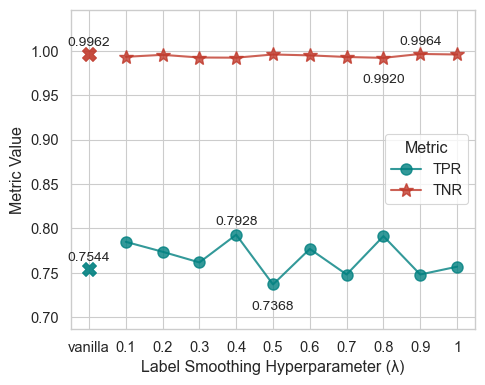


Generating Plot 2: Positive Detection Rate under Attack...


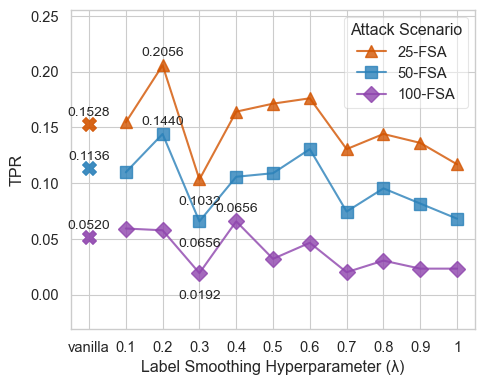

In [23]:
plot_distillation_recalls(df)

## Multistep with Diverse Learned Representations (Figure 5)

### Code

In [15]:
# Imports
import os
import sys
import yaml
from pathlib import Path

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),"android-detectors","src"))
from models.utils import *
from models import RobustMLP, NaturalMLP

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns
from omegaconf import DictConfig, OmegaConf
import torch

# Get data
base_path = os.getcwd()
features_tr = load_features(
    os.path.join(base_path, "../data/training_set_features.zip"))
y_tr = load_labels(
    os.path.join(base_path, "../data/training_set_features.zip"),
    os.path.join(base_path, "../data/training_set.zip"))

vectorizer = CountVectorizer(
            input="content", lowercase=False,
            tokenizer=lambda x: x, binary=True, token_pattern=None)

X = vectorizer.fit_transform(features_tr)
y = y_tr

2025-10-07 13:39:29,845 - py.warnings - WARNING - /opt/miniconda3/envs/android/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(



#### Create data embeddings

In [9]:
# ## 1. Load the MLP models
# #  -- Load naive clf --
# cfg = OmegaConf.load(Path('../experiments/out/natural-train/config.yaml'))
# clf_path = "../experiments/out/natural-train/classifier.ckpt"
# vect_path = "../experiments/out/tab-adv-train-m_2_delta_bound_75_feat_selection_topk/vectorizer.pkl"
# natural_clf = NaturalMLP.load(cfg, vect_path, clf_path)
#
# # -- Load best adv clf --
# cfg = OmegaConf.load(Path('../experiments/out/tab-adv-train-m_2_delta_bound_75_feat_selection_topk/config.yaml'))
# clf_path = "../experiments/out/tab-adv-train-m_2_delta_bound_75_feat_selection_topk/classifier.ckpt"
# vect_path = "../experiments/out/tab-adv-train-m_2_delta_bound_75_feat_selection_topk/vectorizer.pkl"
# best_adv_train_clf = RobustMLP.load(cfg, vect_path, clf_path)
#
# # -- Load second best adv clf --
# cfg = OmegaConf.load(Path('../experiments/out/tab-adv-train-m_2_delta_bound_100_feat_selection_topk/config.yaml'))
# clf_path = "../experiments/out/tab-adv-train-m_2_delta_bound_100_feat_selection_topk/classifier.ckpt"
# vect_path = "../experiments/out/tab-adv-train-m_2_delta_bound_100_feat_selection_topk/vectorizer.pkl"
# sec_best_adv_train_clf = RobustMLP.load(cfg, vect_path, clf_path)
#
# # -- Load smoothing lambda=0.2 clf --
# cfg = OmegaConf.load(Path('../experiments/out/adv-distill-train-distillation_0.2/config.yaml'))
# clf_path = "../experiments/out/adv-distill-train-distillation_0.2/classifier.ckpt"
# vect_path = "../experiments/out/adv-distill-train-distillation_0.2/vectorizer.pkl"
# best_smooth_clf = RobustMLP.load(cfg, vect_path, clf_path)
#
# # -- Load smoothing lambda=0.4 clf --
# cfg = OmegaConf.load(Path('../experiments/out/adv-distill-train-distillation_0.4/config.yaml'))
# clf_path = "../experiments/out/adv-distill-train-distillation_0.4/classifier.ckpt"
# vect_path = "../experiments/out/adv-distill-train-distillation_0.4/vectorizer.pkl"
# sec_best_smooth_clf = RobustMLP.load(cfg, vect_path, clf_path)

In [10]:
# from tqdm import tqdm
#
# trainloader, valloader = natural_clf._load_pt_dataset(X, y)
# y_val = np.zeros(len(valloader.dataset))
#
# # -- Get embeddings for natural clf --
# natural_clf_embeddings = []  # Store embeddings of the negative class
# natural_clf.eval()
# y_pred = np.zeros(len(valloader.dataset))
# with torch.no_grad():
#     for i, example in enumerate(tqdm(valloader, desc="Processing Batches")):
#         features = example[0].to(natural_clf.device)
#         y_val[i * valloader.batch_size:(i + 1) * valloader.batch_size] = example[1].reshape(-1).numpy()
#         outputs, batch_embeddings = natural_clf.forward(features, return_embedding=True)
#         y_pred[i * valloader.batch_size:(i + 1) * valloader.batch_size] = outputs.cpu().squeeze().numpy()
#
#         # Append to list
#         natural_clf_embeddings.append(batch_embeddings.cpu())
# # Convert list of tensors to a single tensor
# natural_clf_embeddings = torch.cat(natural_clf_embeddings, dim=0).numpy()
# np.save('embeddings/natural_clf_embeddings_val.npy', natural_clf_embeddings, allow_pickle=False)
# np.save('embeddings/natural_clf_embeddings_y_val_pred.npy', y_pred, allow_pickle=False)
# np.save('embeddings/y_val.npy', y_val, allow_pickle=False)
#
#
# # -- Get embeddings for best adv clf --
# best_adv_train_clf_embeddings = []  # Store embeddings of the negative class
# best_adv_train_clf.eval()
# y_pred = np.zeros(len(valloader.dataset))
# with torch.no_grad():
#     for i, example in enumerate(tqdm(valloader, desc="Processing Batches")):
#         features = example[0].to(best_adv_train_clf.device)
#         outputs, batch_embeddings = best_adv_train_clf.forward(features, return_embedding=True)
#         y_pred[i * valloader.batch_size:(i + 1) * valloader.batch_size] = outputs.cpu().squeeze().numpy()
#
#         # Append to list
#         best_adv_train_clf_embeddings.append(batch_embeddings.cpu())
# # Convert list of tensors to a single tensor
# best_adv_train_clf_embeddings = torch.cat(best_adv_train_clf_embeddings, dim=0).numpy()
# np.save('embeddings/best_adv_train_clf_embeddings_val.npy', best_adv_train_clf_embeddings, allow_pickle=False)
# np.save('embeddings/best_adv_train_clf_embeddings_y_val_pred.npy', y_pred, allow_pickle=False)
#
#
# # -- Get embeddings for second best adv clf --
# sec_best_adv_train_clf_embeddings = []  # Store embeddings of the negative class
# best_adv_train_clf.eval()
# y_pred = np.zeros(len(valloader.dataset))
# with torch.no_grad():
#     for i, example in enumerate(tqdm(valloader, desc="Processing Batches")):
#         features = example[0].to(sec_best_adv_train_clf.device)
#         outputs, batch_embeddings = sec_best_adv_train_clf.forward(features, return_embedding=True)
#         y_pred[i * valloader.batch_size:(i + 1) * valloader.batch_size] = outputs.cpu().squeeze().numpy()
#
#         # Append to list
#         sec_best_adv_train_clf_embeddings.append(batch_embeddings.cpu())
# # Convert list of tensors to a single tensor
# sec_best_adv_train_clf_embeddings = torch.cat(sec_best_adv_train_clf_embeddings, dim=0).numpy()
# np.save('embeddings/sec_best_adv_train_clf_embeddings_val.npy', sec_best_adv_train_clf_embeddings, allow_pickle=False)
# np.save('embeddings/sec_best_adv_train_clf_embeddings_y_val_pred.npy', y_pred, allow_pickle=False)
#
#
# # -- Get embeddings for best smoothing clf --
# best_smooth_clf_embeddings = []  # Store embeddings of the negative class
# best_smooth_clf.eval()
# y_pred = np.zeros(len(valloader.dataset))
# with torch.no_grad():
#     for i, example in enumerate(tqdm(valloader, desc="Processing Batches")):
#         features = example[0].to(best_smooth_clf.device)
#         outputs, batch_embeddings = best_smooth_clf.forward(features, return_embedding=True)
#         y_pred[i * valloader.batch_size:(i + 1) * valloader.batch_size] = outputs.cpu().squeeze().numpy()
#
#         # Append to list
#         best_smooth_clf_embeddings.append(batch_embeddings.cpu())
# # Convert list of tensors to a single tensor
# best_smooth_clf_embeddings = torch.cat(best_smooth_clf_embeddings, dim=0).numpy()
# np.save('embeddings/best_smooth_clf_embeddings_val.npy', best_smooth_clf_embeddings, allow_pickle=False)
# np.save('embeddings/best_smooth_clf_embeddings_y_val_pred.npy', y_pred, allow_pickle=False)
#
#
# # -- Get embeddings for second best smoothing clf --
# sec_best_smooth_clf_embeddings = []  # Store embeddings of the negative class
# sec_best_smooth_clf.eval()
# y_pred = np.zeros(len(valloader.dataset))
# with torch.no_grad():
#     for i, example in enumerate(tqdm(valloader, desc="Processing Batches")):
#         features = example[0].to(sec_best_smooth_clf.device)
#         outputs, batch_embeddings = sec_best_smooth_clf.forward(features, return_embedding=True)
#         y_pred[i * valloader.batch_size:(i + 1) * valloader.batch_size] = outputs.cpu().squeeze().numpy()
#
#         # Append to list
#         sec_best_smooth_clf_embeddings.append(batch_embeddings.cpu())
# # Convert list of tensors to a single tensor
# sec_best_smooth_clf_embeddings = torch.cat(sec_best_smooth_clf_embeddings, dim=0).numpy()
# np.save('embeddings/sec_best_smooth_clf_embeddings_val.npy', sec_best_smooth_clf_embeddings, allow_pickle=False)
# np.save('embeddings/sec_best_smooth_clf_embeddings_y_val_pred.npy', y_pred, allow_pickle=False)

### Figure

2025-10-07 14:06:10,529 - py.warnings - WARNING - /opt/miniconda3/envs/android/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

Successfully loaded true labels from y_val.npy. Shape: (15000,)

Processing model: natural_clf
  - Performing t-SNE on all 15000 points... (this may take a moment)
  - Plotting t-SNE with a random sample of 2000 points.


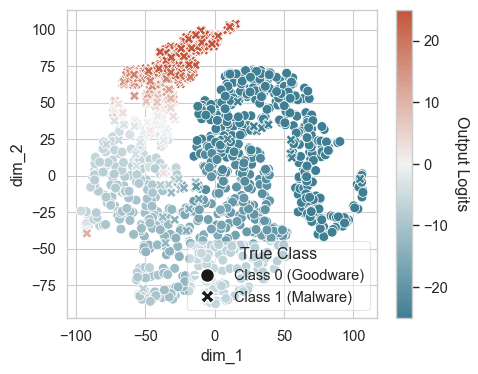

  - Performing UMAP on all 15000 points... (this may take a moment)
2025-10-07 14:06:41,248 - py.warnings - WARNING - /opt/miniconda3/envs/android/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

2025-10-07 14:06:41,251 - py.warnings - WARNING - /opt/miniconda3/envs/android/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  - Plotting UMAP with a random sample of 2000 points.


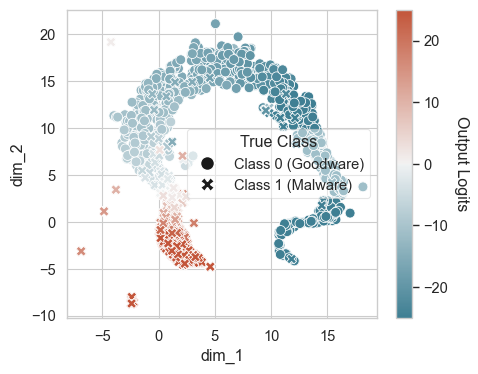


Processing model: best_adv_train_clf
  - Performing t-SNE on all 15000 points... (this may take a moment)
  - Plotting t-SNE with a random sample of 2000 points.


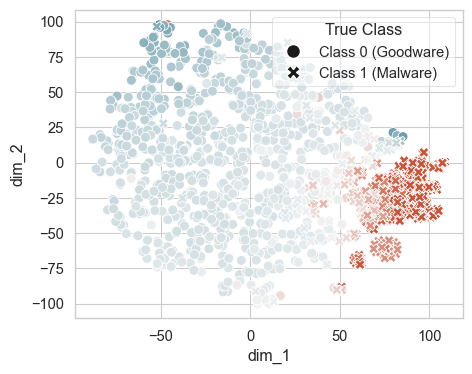

  - Performing UMAP on all 15000 points... (this may take a moment)
2025-10-07 14:07:25,775 - py.warnings - WARNING - /opt/miniconda3/envs/android/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

2025-10-07 14:07:25,777 - py.warnings - WARNING - /opt/miniconda3/envs/android/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  - Plotting UMAP with a random sample of 2000 points.


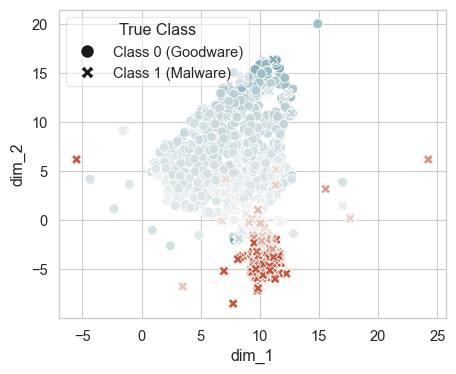


Processing model: sec_best_adv_train_clf
  - Performing t-SNE on all 15000 points... (this may take a moment)
  - Plotting t-SNE with a random sample of 2000 points.


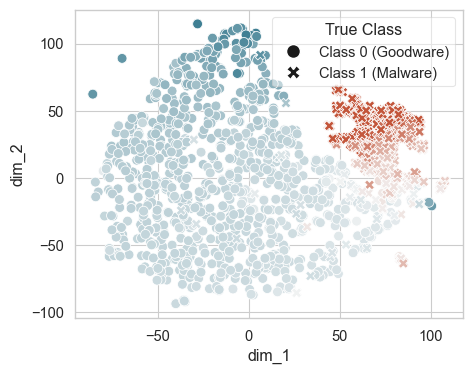

  - Performing UMAP on all 15000 points... (this may take a moment)
2025-10-07 14:08:03,073 - py.warnings - WARNING - /opt/miniconda3/envs/android/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

2025-10-07 14:08:03,074 - py.warnings - WARNING - /opt/miniconda3/envs/android/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  - Plotting UMAP with a random sample of 2000 points.


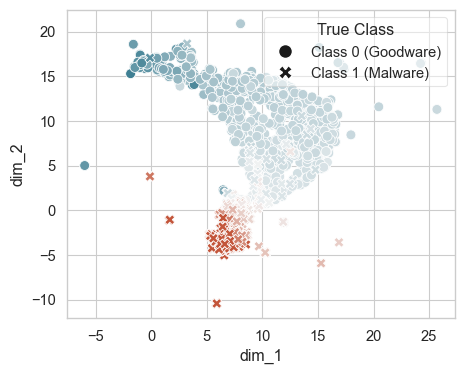


Processing model: best_smooth_clf
  - Performing t-SNE on all 15000 points... (this may take a moment)
  - Plotting t-SNE with a random sample of 2000 points.


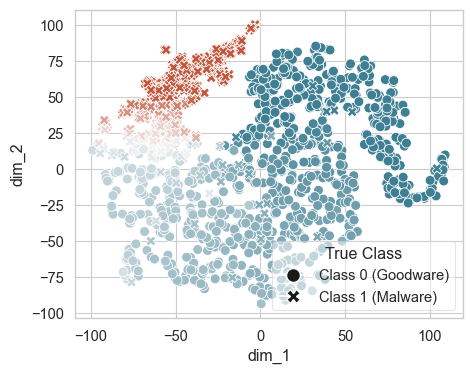

  - Performing UMAP on all 15000 points... (this may take a moment)
2025-10-07 14:08:41,278 - py.warnings - WARNING - /opt/miniconda3/envs/android/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

2025-10-07 14:08:41,279 - py.warnings - WARNING - /opt/miniconda3/envs/android/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  - Plotting UMAP with a random sample of 2000 points.


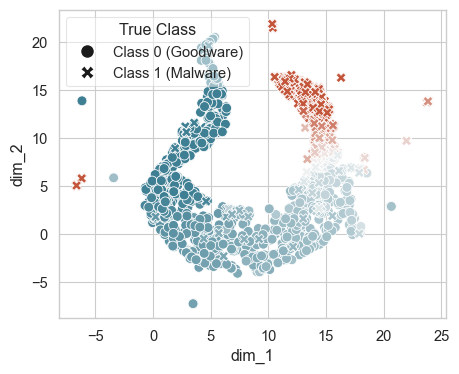


Processing model: sec_best_smooth_clf
  - Performing t-SNE on all 15000 points... (this may take a moment)
  - Plotting t-SNE with a random sample of 2000 points.


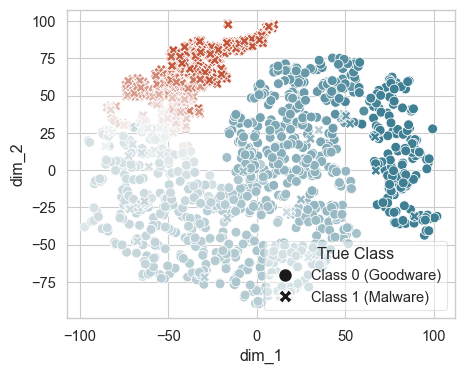

  - Performing UMAP on all 15000 points... (this may take a moment)
2025-10-07 14:09:20,298 - py.warnings - WARNING - /opt/miniconda3/envs/android/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

2025-10-07 14:09:20,299 - py.warnings - WARNING - /opt/miniconda3/envs/android/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

  - Plotting UMAP with a random sample of 2000 points.


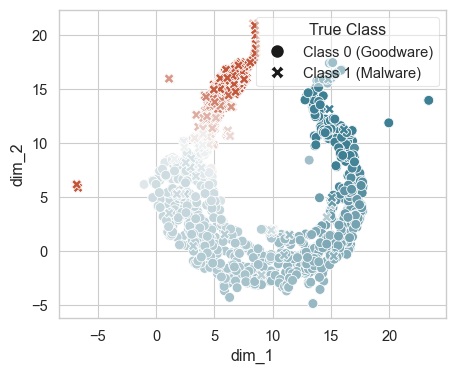


All models processed.


In [24]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import trimap
from umap import UMAP # Added UMAP import
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
# List of model prefixes as used in your filenames
MODEL_PREFIXES = [
    'natural_clf',
    'best_adv_train_clf',
    'sec_best_adv_train_clf',
    'best_smooth_clf',
    'sec_best_smooth_clf'
]

# A dictionary for prettier titles in the plots
PLOT_TITLES = {
    'natural_clf': 'natural',
    'best_adv_train_clf': 'adversarial-75',
    'sec_best_adv_train_clf': 'adversarial-100',
    'best_smooth_clf': 'smoothed-0.2',
    'sec_best_smooth_clf': 'smoothed-0.4'
}

# --- Sampling Configuration ---
# Set the number of points from each class to plot.
# The layout will still be calculated on the FULL dataset.
N_GOODWARE_TO_PLOT = 1000  # Number of Class 0 points to plot
N_MALWARE_TO_PLOT = 1000   # Number of Class 1 points to plot
RANDOM_STATE_FOR_SAMPLING = 42 # Ensures the same random points are chosen every time

# --- Load True Labels ---
try:
    y_true = np.load('embeddings/y_val.npy')
    print(f"Successfully loaded true labels from y_val.npy. Shape: {y_true.shape}")
except FileNotFoundError:
    print("Error: 'y_val.npy' not found. Please ensure the file is in the correct directory.")
    exit()


# --- Generic Visualization Function (Modified to handle method name) ---
def create_landscape_plot(df, title, method_name="Dimension"):
    """
    Generic plotting function that takes a DataFrame with coordinates,
    labels, and projections, and shows a plot.
    """
    # --- 1. COMMON SETUP FOR ALL PLOTS ---
    sns.set_theme(context="paper", style="whitegrid", font_scale=1.2)

    # Hardcoded vmax for consistent color scaling across all plots
    vmax = 25
    hue_normalization = (-vmax, vmax)

    plt.figure(figsize=(5, 4))
    ax = sns.scatterplot(
        data=df,
        x='dim_1',
        y='dim_2',
        hue='projection',
        hue_norm=hue_normalization,
        style='label',     # Style by the true class label
        palette=sns.diverging_palette(220, 20, as_cmap=True),
        s=50,
        markers=['o', 'X'],
        alpha=1
    )

    # Customize legend and colorbar
    if title == "natural":
        norm = plt.Normalize(vmin=-vmax, vmax=vmax)
        sm = plt.cm.ScalarMappable(cmap=sns.diverging_palette(220, 20, as_cmap=True), norm=norm)
        sm.set_array([])
        ax.get_legend().remove()
        cbar = ax.figure.colorbar(sm, ax=ax)
        cbar.set_label('Output Logits', rotation=270, labelpad=15)

    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', label='Class 0 (Goodware)', markersize=10),
        plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='k', label='Class 1 (Malware)', markersize=10)
    ]
    ax.legend(handles=legend_handles, title='True Class', framealpha=0.5)

    #plt.title(f"{title} - {method_name}")
    os.makedirs('figures', exist_ok=True)
    plt.savefig(f"figures/{title}-{method_name}.pdf")

    # Show the plot interactively
    plt.show()


# --- Main Loop to Generate Plots ---
for prefix in MODEL_PREFIXES:
    try:
        # Load the data for the current model
        embeddings_file = f'embeddings/{prefix}_embeddings_val.npy'
        projections_file = f'embeddings/{prefix}_embeddings_y_val_pred.npy'

        print(f"\nProcessing model: {prefix}")
        embeddings = np.load(embeddings_file)
        projections = np.load(projections_file).flatten()

        if embeddings.shape[0] != y_true.shape[0]:
            print(f"  - Warning: Mismatch in data lengths for {prefix}. Skipping.")
            continue

        # --- Process and Plot for TriMap ---
        # print(f"  - Performing TriMap on all {len(embeddings)} points... (this may take a moment)")
        # trimap_reducer = trimap.TRIMAP(n_dims=2)
        # embeddings_2d_trimap = trimap_reducer.fit_transform(embeddings)
        #
        # df_full_trimap = pd.DataFrame({
        #     'dim_1': embeddings_2d_trimap[:, 0], 'dim_2': embeddings_2d_trimap[:, 1],
        #     'label': y_true.astype(int), 'projection': projections
        # })
        #
        # df_goodware_trimap = df_full_trimap[df_full_trimap['label'] == 0]
        # df_malware_trimap = df_full_trimap[df_full_trimap['label'] == 1]
        #
        # n_goodware_to_sample = min(N_GOODWARE_TO_PLOT, len(df_goodware_trimap))
        # n_malware_to_sample = min(N_MALWARE_TO_PLOT, len(df_malware_trimap))
        #
        # goodware_sample_trimap = df_goodware_trimap.sample(n=n_goodware_to_sample, random_state=RANDOM_STATE_FOR_SAMPLING)
        # malware_sample_trimap = df_malware_trimap.sample(n=n_malware_to_sample, random_state=RANDOM_STATE_FOR_SAMPLING)
        #
        # df_sampled_trimap = pd.concat([goodware_sample_trimap, malware_sample_trimap])
        # print(f"  - Plotting TriMap with a random sample of {len(df_sampled_trimap)} points.")
        # create_landscape_plot(df_sampled_trimap, f"{PLOT_TITLES.get(prefix, prefix)}", method_name="TriMap")


        # --- Process and Plot for t-SNE ---
        print(f"  - Performing t-SNE on all {len(embeddings)} points... (this may take a moment)")
        tsne_reducer = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
        embeddings_2d_tsne = tsne_reducer.fit_transform(embeddings)

        df_full_tsne = pd.DataFrame({
            'dim_1': embeddings_2d_tsne[:, 0], 'dim_2': embeddings_2d_tsne[:, 1],
            'label': y_true.astype(int), 'projection': projections
        })

        df_goodware_tsne = df_full_tsne[df_full_tsne['label'] == 0]
        df_malware_tsne = df_full_tsne[df_full_tsne['label'] == 1]

        n_goodware_to_sample = min(N_GOODWARE_TO_PLOT, len(df_goodware_tsne))
        n_malware_to_sample = min(N_MALWARE_TO_PLOT, len(df_malware_tsne))

        goodware_sample_tsne = df_goodware_tsne.sample(n=n_goodware_to_sample, random_state=RANDOM_STATE_FOR_SAMPLING)
        malware_sample_tsne = df_malware_tsne.sample(n=n_malware_to_sample, random_state=RANDOM_STATE_FOR_SAMPLING)

        df_sampled_tsne = pd.concat([goodware_sample_tsne, malware_sample_tsne])
        print(f"  - Plotting t-SNE with a random sample of {len(df_sampled_tsne)} points.")
        create_landscape_plot(df_sampled_tsne, f"{PLOT_TITLES.get(prefix, prefix)}", method_name="t-SNE")

        # --- Process and Plot for UMAP ---
        print(f"  - Performing UMAP on all {len(embeddings)} points... (this may take a moment)")
        umap_reducer = UMAP(n_components=2, random_state=42)
        embeddings_2d_umap = umap_reducer.fit_transform(embeddings)

        df_full_umap = pd.DataFrame({
            'dim_1': embeddings_2d_umap[:, 0], 'dim_2': embeddings_2d_umap[:, 1],
            'label': y_true.astype(int), 'projection': projections
        })

        df_goodware_umap = df_full_umap[df_full_umap['label'] == 0]
        df_malware_umap = df_full_umap[df_full_umap['label'] == 1]

        n_goodware_to_sample = min(N_GOODWARE_TO_PLOT, len(df_goodware_umap))
        n_malware_to_sample = min(N_MALWARE_TO_PLOT, len(df_malware_umap))

        goodware_sample_umap = df_goodware_umap.sample(n=n_goodware_to_sample, random_state=RANDOM_STATE_FOR_SAMPLING)
        malware_sample_umap = df_malware_umap.sample(n=n_malware_to_sample, random_state=RANDOM_STATE_FOR_SAMPLING)

        df_sampled_umap = pd.concat([goodware_sample_umap, malware_sample_umap])
        print(f"  - Plotting UMAP with a random sample of {len(df_sampled_umap)} points.")
        create_landscape_plot(df_sampled_umap, f"{PLOT_TITLES.get(prefix, prefix)}", method_name="UMAP")


    except FileNotFoundError as e:
        print(f"  - Error: Could not find a required file for '{prefix}'. Skipping. Missing file: {e.filename}")
    except Exception as e:
        print(f"  - An unexpected error occurred for '{prefix}': {e}")


print("\nAll models processed.")

## Multi-step variations (Table 3)

Loading projection scores for all models...
  - Loaded scores for natural
  - Loaded scores for adversarial-75
  - Loaded scores for adversarial-100
  - Loaded scores for smoothing-0.2
  - Loaded scores for Smoothing-0.6

--- Cross-Correlation Matrix of Projection Scores ---
                 natural  adversarial-75  adversarial-100  smoothing-0.2  \
natural           1.0000          0.8157           0.8678         0.9655   
adversarial-75    0.8157          1.0000           0.9228         0.8690   
adversarial-100   0.8678          0.9228           1.0000         0.9132   
smoothing-0.2     0.9655          0.8690           0.9132         1.0000   
Smoothing-0.6     0.9257          0.8589           0.8877         0.9434   

                 Smoothing-0.6  
natural                 0.9257  
adversarial-75          0.8589  
adversarial-100         0.8877  
smoothing-0.2           0.9434  
Smoothing-0.6           1.0000  


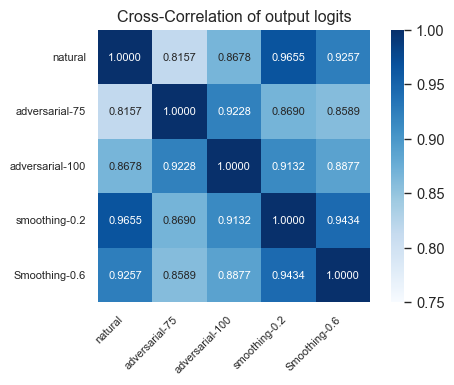

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
# List of model prefixes as used in your filenames
MODEL_PREFIXES = [
    'natural_clf',
    'best_adv_train_clf',
    'sec_best_adv_train_clf',
    'best_smooth_clf',
    'sec_best_smooth_clf'
]

# Use shorter, clearer names for the table and plot
PLOT_TITLES = {
    'natural_clf': 'natural',
    'best_adv_train_clf': 'adversarial-75',
    'sec_best_adv_train_clf': 'adversarial-100',
    'best_smooth_clf': 'smoothing-0.2',
    'sec_best_smooth_clf': 'Smoothing-0.6'
}


# --- Step 1: Load all projection scores into a dictionary ---
all_scores = {}
print("Loading projection scores for all models...")
for prefix in MODEL_PREFIXES:
    try:
        projections_file = f'embeddings/{prefix}_embeddings_y_val_pred.npy'
        # Use the nice titles for dictionary keys
        model_name = PLOT_TITLES.get(prefix, prefix)
        all_scores[model_name] = np.load(projections_file).flatten()
        print(f"  - Loaded scores for {model_name}")
    except FileNotFoundError:
        print(f"  - Warning: Could not find file for '{prefix}'. Skipping.")
        continue

# --- Step 2: Create a single pandas DataFrame from the scores ---
# This aligns all scores by their sample index
scores_df = pd.DataFrame(all_scores)


# --- Step 3: Calculate the correlation matrix ---
# The .corr() method computes the Pearson correlation between columns
correlation_matrix = scores_df.corr()


# --- Step 4: Print the correlation table ---
print("\n--- Cross-Correlation Matrix of Projection Scores ---")
# Print the matrix rounded to 4 decimal places for clarity
print(correlation_matrix.round(4))


# --- Step 5: Visualize the matrix as a heatmap ---
plt.figure(figsize=(5, 4))
heatmap = sns.heatmap(
    correlation_matrix,
    vmin=0.75, vmax=1,      # Set the color bar range from -1 to 1
    annot=True,          # Write the data values on the squares
    cmap='Blues',     # Use a diverging colormap
    fmt='.4f',          # Format annotations to two decimal places
    square=True,
    annot_kws={
        "fontsize": 8,
    }
)
plt.title('Cross-Correlation of output logits')
# Ensure labels fit on the plot
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels overlapping

os.makedirs('figures', exist_ok=True)
plt.savefig("figures/logit-correlation.pdf")

# Save the figure
plt.show()

In [27]:
import pandas as pd
import numpy as np

# The DataFrame 'df' is assumed to be already loaded and available.

# --- 1. Define Constants and F1 Score Calculation Function ---
TOTAL_POSITIVES = 1250
TOTAL_NEGATIVES = 5000

def calculate_f1(row):
    """Calculates F1 score from recall and specificity."""
    recall = row['Positive_recall']
    specificity = row['Negative_specificity']

    # Handle cases where metrics might be missing
    if pd.isna(recall) or pd.isna(specificity):
        return np.nan

    # Derive TP, TN, and FP from the given metrics and totals
    true_positives = recall * TOTAL_POSITIVES
    true_negatives = specificity * TOTAL_NEGATIVES
    false_positives = TOTAL_NEGATIVES - true_negatives

    # Calculate precision, handling division by zero
    if (true_positives + false_positives) == 0:
        precision = 0.0
    else:
        precision = true_positives / (true_positives + false_positives)

    # Calculate F1 score, handling division by zero
    if (precision + recall) == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score


# --- 2. Filter for the relevant models ---
model_prefixes = ('multistep-divergent-t3_0.0', 'multistep-convergent-t3_0.0', 'ensemble-convergent', 'ensemble-divergent','natural-train',
                  'tab-adv-train-m_2_delta_bound_75_feat_selection_topk', 'tab-adv-train-m_2_delta_bound_100_feat_selection_topk')
filtered_df = df[df['model_name'].isin(model_prefixes)].copy()

# 3. Select the required columns for the table
#    We need the source metrics to calculate the F1 score.
table_df = filtered_df[[
    'model_name',
    'Negative_specificity',
    'Positive_recall',
    '25-FSA_recall',
    '50-FSA_recall',
    '100-FSA_recall'
]].copy()

# 4. Apply the function to each row to create the new 'F1 Score' column
table_df['F1 Score'] = table_df.apply(calculate_f1, axis=1)
# Put in the fourth position for better visibility
table_df.insert(3, 'F1 Score', table_df.pop('F1 Score'))

# 7. Sort the DataFrame for clean presentation
table_df.sort_values(by=['model_name'], inplace=True)

# 8. Display the final, processed DataFrame with the new F1 Score column
print("--- Filtered and Sorted DataFrame for Multi-Step Models (with F1 Score) ---")
table_df

--- Filtered and Sorted DataFrame for Multi-Step Models (with F1 Score) ---


,model_name,Negative_specificity,Positive_recall,F1 Score,25-FSA_recall,50-FSA_recall,100-FSA_recall
54,ensemble-convergent,0.9896,0.8304,0.887179,0.4232,0.2240,0.1056
68,ensemble-divergent,0.9948,0.7960,0.876266,0.2128,0.1400,0.0576
16,multistep-convergent-t3_0.0,0.9802,0.8544,0.883740,0.5608,0.3016,0.1680
61,multistep-divergent-t3_0.0,0.9834,0.8496,0.886848,0.4008,0.1952,0.1056
15,natural-train,0.9962,0.7544,0.852622,0.1528,0.1136,0.0520
1,tab-adv-train-m_2_delta_bound_100_feat_selecti...,0.9894,0.8136,0.876724,0.3136,0.1728,0.1000
2,tab-adv-train-m_2_delta_bound_75_feat_selectio...,0.9844,0.8424,0.884502,0.3768,0.1760,0.0960


## Results of our models (Table 5)

In [45]:
import os
import json
from pathlib import Path

# Load evaluation
folder = Path("../submissions")

for submission in os.listdir(folder):
    print(f"Submission: {submission}")
    if submission.endswith("track_1.json"):
        with open(f"{folder}/{submission}") as f:
            eval_data = json.load(f)
        model_name = eval_data[0].get("name", folder.name)
        metrics = {"submission_name": submission}
        partitions = ['Negative', 'Positive', '25-FSA', '50-FSA', '100-FSA']
        threshold = 0.5
        for idx, partition in zip(range(0, 5), partitions):
                entry = eval_data[idx]
                y_true = [0 for v in entry.values()] if partition == 'Negative' else [1 for v in entry.values()]
                y_scores = [v[1] for v in entry.values()]
                y_pred = [1 if s >= threshold else 0 for s in y_scores]

                #precision = precision_score(y_true, y_pred, zero_division=0)
                recall = recall_score(y_true, y_pred, zero_division=0) if partition != 'Negative' else None
                #f1 = f1_score(y_true, y_pred, zero_division=0)
                specificity = compute_specificity(y_true, y_pred) if partition == 'Negative' else None

                #metrics[f"{partition}_precision"] = precision
                metrics[f"{partition}_recall"] = recall
                metrics[f"{partition}_specificity"] = specificity
                #metrics[f"{partition}_f1"] = f1

        print(metrics)

Submission: submission_deeptrust_track_1.json
{'submission_name': 'submission_deeptrust_track_1.json', 'Negative_recall': None, 'Negative_specificity': 0.9902, 'Positive_recall': 0.7832, 'Positive_specificity': None, '25-FSA_recall': 0.4328, '25-FSA_specificity': None, '50-FSA_recall': 0.3384, '50-FSA_specificity': None, '100-FSA_recall': 0.1992, '100-FSA_specificity': None}
Submission: .gitkeep
Submission: submission_guardnet_track_1.json
{'submission_name': 'submission_guardnet_track_1.json', 'Negative_recall': None, 'Negative_specificity': 0.983, 'Positive_recall': 0.8016, 'Positive_specificity': None, '25-FSA_recall': 0.4704, '25-FSA_specificity': None, '50-FSA_recall': 0.2656, '50-FSA_specificity': None, '100-FSA_recall': 0.124, '100-FSA_specificity': None}
Submission: submission_xgboost_track_1.json
{'submission_name': 'submission_xgboost_track_1.json', 'Negative_recall': None, 'Negative_specificity': 0.9988, 'Positive_recall': 0.7336, 'Positive_specificity': None, '25-FSA_recall

## Isolation Forest as an activation condition

### Code

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_multistep_performance(df: pd.DataFrame):
    """
    Generates six separate plots to analyze multi-step models.
    For each model type (Convergent, Divergent), it plots:
    1. Positive Detection Rate (Recall) on Clean Data.
    2. Positive Detection Rate (Recall) under Attack.
    3. Negative Detection Rate (Specificity) on Clean Data.
    """
    # --- 1. COMMON SETUP FOR ALL PLOTS ---
    sns.set_theme(context="paper", style="whitegrid", font_scale=1.2)
    df["multi_step.t3"] = pd.to_numeric(df["multi_step.t3"], errors="coerce")

    # --- 2. LOOP THROUGH MODEL TYPES TO GENERATE PLOTS ---
    for model_type in ["convergent", "divergent"]:

        # --- Data Preparation for the current model_type ---
        model_prefix = f"multistep-{model_type}"
        model_df = df[df["model_name"].str.startswith(model_prefix, na=False)].copy()

        if model_df.empty:
            print(f"No data for '{model_type}' models, skipping plots.")
            continue

        baseline_points = model_df[model_df["multi_step.t3"] == 0].copy()
        hyperparameter_points = model_df[model_df["multi_step.t3"] != 0].copy()

        # --- PLOT 1 for model_type: RECALL ON CLEAN DATA ---
        print(f"\n--- Generating Plot: {model_type.capitalize()} Models - Recall on Clean Data ---")
        plt.figure(figsize=(7, 3))
        recall_col = "Positive_recall"
        color = "#008080"
        marker = 'o'

        # ... (Plotting logic for Positive Recall - same as before) ...
        grouped = hyperparameter_points.groupby("multi_step.t3")[recall_col].mean().dropna()
        xs, ys = sorted(grouped.index), grouped.loc[sorted(grouped.index)].values
        if len(xs) > 0:
            plt.plot(xs, ys, label="Clean Data", color=color, marker=marker, linestyle='-', markersize=8, alpha=0.8, linewidth=1.5)
            if len(ys) > 0:
                max_idx, min_idx = np.argmax(ys), np.argmin(ys)
                plt.annotate(f"{ys[max_idx]:.4f}", (xs[max_idx], ys[max_idx]), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
                if min_idx != max_idx:
                    plt.annotate(f"{ys[min_idx]:.4f}", (xs[min_idx], ys[min_idx]), textcoords="offset points", xytext=(0, -18), ha='center', fontsize=10)
        if not baseline_points.empty and recall_col in baseline_points.columns:
            recall_val = baseline_points[recall_col].mean()
            if pd.notna(recall_val):
                plt.scatter([0], [recall_val], color=color, marker='X', s=100, zorder=5)
                plt.annotate(f"{recall_val:.4f}", (0, recall_val), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=10)
        plt.title(f"{model_type.capitalize()} Models: Positive Detection Rate (Clean)")
        plt.xlabel("Isolation Forest Contamination Hyperparameter")
        plt.ylabel("Recall")
        all_hyperparams = hyperparameter_points['multi_step.t3'].dropna().unique()
        custom_xticks = [0] + sorted(all_hyperparams)
        custom_xtick_labels = ["vanilla"] + [str(int(x)) if x == int(x) else str(x) for x in sorted(all_hyperparams)]
        plt.xticks(custom_xticks, custom_xtick_labels)
        all_data = pd.concat([hyperparameter_points.get(recall_col), baseline_points.get(recall_col)]).dropna()
        if not all_data.empty:
            plt.ylim(max(0, min(all_data) - 0.05), min(1, max(all_data) + 0.05))
        plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

        # --- PLOT 2 for model_type: RECALL ON MANIPULATED DATA ---
        print(f"\n--- Generating Plot: {model_type.capitalize()} Models - Recall under Attack ---")
        plt.figure(figsize=(7, 3))

        # ... (Plotting logic for Manipulated Recall - same as before) ...
        color_map = {"25-FSA": "#d35400", "50-FSA": "#2980b9", "100-FSA": "#8e44ad"}
        marker_map = {"25-FSA": '^', "50-FSA": 's', "100-FSA": 'D'}
        attack_scenarios = ['25-FSA', '50-FSA', '100-FSA']
        all_recalls_attack, all_hyperparams_attack = [], []
        for attack_name in attack_scenarios:
            recall_col_attack = f"{attack_name}_recall"
            grouped_attack = hyperparameter_points.groupby("multi_step.t3")[recall_col_attack].mean().dropna()
            xs_attack, ys_attack = sorted(grouped_attack.index), grouped_attack.loc[sorted(grouped_attack.index)].values
            if len(xs_attack) > 0:
                plt.plot(xs_attack, ys_attack, label=f"{attack_name}", color=color_map.get(attack_name), marker=marker_map.get(attack_name), linestyle='-', markersize=8, alpha=0.8, linewidth=1.5)
                all_recalls_attack.extend(ys_attack); all_hyperparams_attack.extend(xs_attack)
                if len(ys_attack) > 0:
                    max_idx, min_idx = np.argmax(ys_attack), np.argmin(ys_attack)
                    plt.annotate(f"{ys_attack[max_idx]:.4f}", (xs_attack[max_idx], ys_attack[max_idx]), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
                    if min_idx != max_idx:
                        plt.annotate(f"{ys_attack[min_idx]:.4f}", (xs_attack[min_idx], ys_attack[min_idx]), textcoords="offset points", xytext=(0, -18), ha='center', fontsize=10)
            if not baseline_points.empty and recall_col_attack in baseline_points.columns:
                recall_val_attack = baseline_points[recall_col_attack].mean()
                if pd.notna(recall_val_attack):
                    plt.scatter([0], [recall_val_attack], color=color_map.get(attack_name), marker='X', s=100, zorder=5)
                    plt.annotate(f"{recall_val_attack:.4f}", (0, recall_val_attack), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=10)
                    all_recalls_attack.append(recall_val_attack)
        plt.title(f"{model_type.capitalize()} Models: Positive Detection Rate (Attacks)")
        plt.xlabel("Isolation Forest Contamination Hyperparameter")
        plt.ylabel("Recall")
        unique_xs_attack = sorted(list(set(all_hyperparams_attack)))
        custom_xticks_attack = [0] + unique_xs_attack
        custom_xtick_labels_attack = ["vanilla"] + [str(int(x)) if x == int(x) else str(x) for x in unique_xs_attack]
        plt.xticks(custom_xticks_attack, custom_xtick_labels_attack)
        if all_recalls_attack:
            plt.ylim(max(0, min(all_recalls_attack) - 0.05), min(1, max(all_recalls_attack) + 0.05))
        plt.legend(title="Attack Scenario", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

        # --- NEW: PLOT 3 for model_type: NEGATIVE SPECIFICITY ---
        print(f"\n--- Generating Plot: {model_type.capitalize()} Models - Negative Specificity ---")
        plt.figure(figsize=(7, 3))

        spec_col = "Negative_specificity"
        spec_color = "#c0392b"  # Pomegranate Red
        spec_marker = '*'       # Star

        # Process and plot data
        grouped_spec = hyperparameter_points.groupby("multi_step.t3")[spec_col].mean().dropna()
        xs_spec, ys_spec = sorted(grouped_spec.index), grouped_spec.loc[sorted(grouped_spec.index)].values

        if len(xs_spec) > 0:
            plt.plot(xs_spec, ys_spec, label="Specificity", color=spec_color, marker=spec_marker,
                     linestyle='-', markersize=10, alpha=0.8, linewidth=1.5)
            if len(ys_spec) > 0:
                max_idx, min_idx = np.argmax(ys_spec), np.argmin(ys_spec)
                plt.annotate(f"{ys_spec[max_idx]:.4f}", (xs_spec[max_idx], ys_spec[max_idx]), textcoords="offset points", xytext=(0, 7), ha='center', fontsize=10)
                if min_idx != max_idx:
                    plt.annotate(f"{ys_spec[min_idx]:.4f}", (xs_spec[min_idx], ys_spec[min_idx]), textcoords="offset points", xytext=(0, -18), ha='center', fontsize=10)

        # Plot baseline point (T3=0)
        if not baseline_points.empty and spec_col in baseline_points.columns:
            spec_val = baseline_points[spec_col].mean()
            if pd.notna(spec_val):
                plt.scatter([0], [spec_val], color=spec_color, marker='X', s=100, zorder=5)
                plt.annotate(f"{spec_val:.4f}", (0, spec_val), textcoords="offset points", xytext=(0, 6), ha='center', fontsize=10)

        # Final plot configuration
        plt.title(f"{model_type.capitalize()} Models: Negative Detection Rate (Specificity)")
        plt.xlabel("Isolation Forest Contamination Hyperparameter")
        plt.ylabel("Specificity")

        all_hyperparams_spec = hyperparameter_points['multi_step.t3'].dropna().unique()
        custom_xticks_spec = [0] + sorted(all_hyperparams_spec)
        custom_xtick_labels_spec = ["vanilla"] + [str(int(x)) if x == int(x) else str(x) for x in sorted(all_hyperparams_spec)]
        plt.xticks(custom_xticks_spec, custom_xtick_labels_spec)

        all_data_spec = pd.concat([hyperparameter_points.get(spec_col), baseline_points.get(spec_col)]).dropna()
        if not all_data_spec.empty:
            plt.ylim(max(0, min(all_data_spec) - 0.05), min(1, max(all_data_spec) + 0.05))

        plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

### Figure


--- Generating Plot: Convergent Models - Recall on Clean Data ---


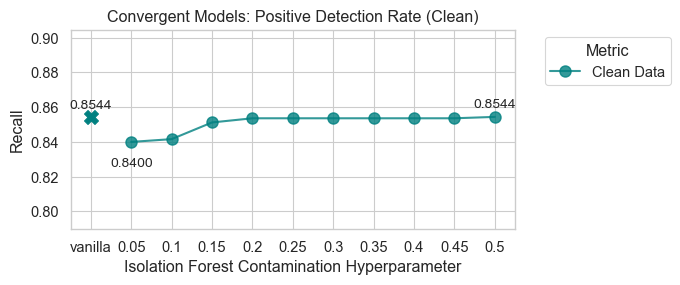


--- Generating Plot: Convergent Models - Recall under Attack ---


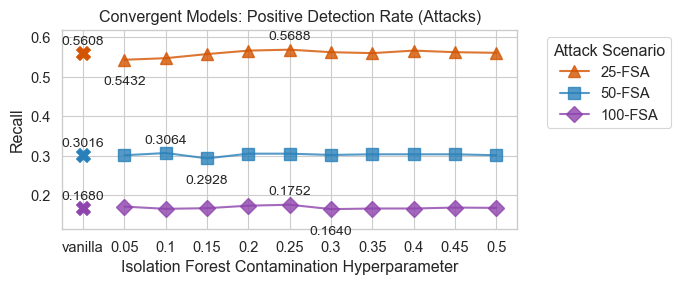


--- Generating Plot: Convergent Models - Negative Specificity ---


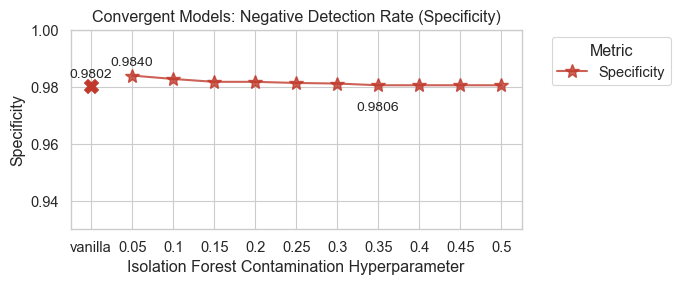


--- Generating Plot: Divergent Models - Recall on Clean Data ---


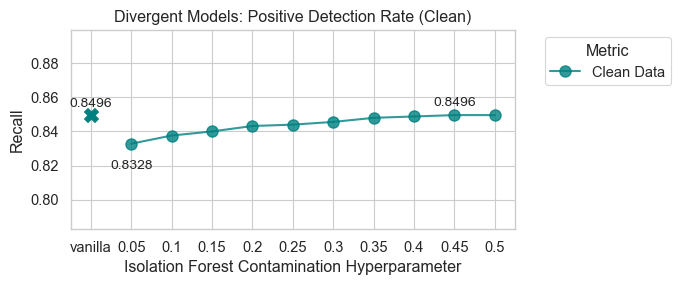


--- Generating Plot: Divergent Models - Recall under Attack ---


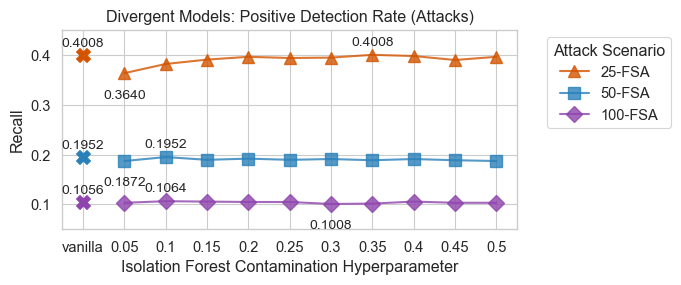


--- Generating Plot: Divergent Models - Negative Specificity ---


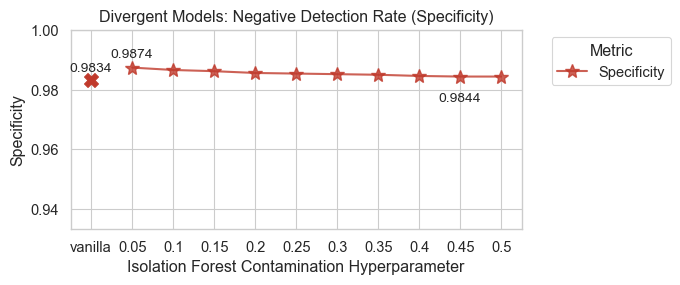

In [44]:
plot_multistep_performance(df)